In [77]:
# In the root of the repo run "pip install --editable ."

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Normalization of Power Signal

Author: Clemens Jochum

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from src.data.import_data import import_df_from_zip_pkl, import_df_info_from_zip
from src.features.performance_index import normalize_power_signal
from src.data.make_dataset import downsample_dataframe

In [79]:
from warnings import filterwarnings
filterwarnings('ignore')

#plt.rcParams["figure.figsize"] = [10, 5]
#plt.rcParams['figure.dpi'] = 250
#'font.size': 10, 'savefig.dpi': 72, 'figure.subplot.bottom': 0.125

### Import Datasets

Import a range of datasets for each type of synthetic data.

In [85]:
data_key = 'basic'

n_samples = 50
path_to_data_raw = '../data/raw/'
path_to_dataset = '{0:s}/synthetic_{1:s}.zip'.format(path_to_data_raw, data_key)

In [86]:
poa_reference_02 = pd.read_pickle('../data/raw/clear_sky_CO.pkl', compression='gzip')

t_begin = pd.Timestamp('2015-01-01 00:00:00').tz_localize('Etc/GMT+7')
t_final = pd.Timestamp('2019-12-31 23:59:00').tz_localize('Etc/GMT+7')
datetime_01 = pd.date_range(t_begin, poa_reference_02.index[0], freq='min')[:-1]
datetime_03 = pd.date_range(poa_reference_02.index[-1], t_final, freq='min')[1:]

poa_reference_01 = pd.Series(data=0., index=datetime_01, name='POAcs')
poa_reference_03 = pd.Series(data=0., index=datetime_03, name='POAcs')

poa_reference_co = pd.concat((poa_reference_01, poa_reference_02, poa_reference_03))

#print(pd.Timedelta(poa_reference_02.index[0] - t_begin).seconds / 60)
#print(pd.Timedelta(t_final - poa_reference_02.index[-1]).seconds / 60)
#print(pd.date_range(t_begin, poa_reference_02.index[0], freq='min')[:-1].size)
#print(pd.date_range(poa_reference_02.index[-1], t_final, freq='min')[1:].size)

#poa_reference[:7*1440].plot()
#print(df.POA.size - poa_reference.size)


In [87]:
for index in range(n_samples):
    df = import_df_from_zip_pkl(path_to_dataset, index)
    
    outlier_threshold = 0.0
    
    if data_key in ['basic', 'soil']:
        clearsky = False
    else:
        clearsky = True
    
    if data_key in ['basic', 'soil']:
        poa_reference = None
    elif data_key in ['soil_weather', 'weather']:
        poa_reference = poa_reference_co
    
    p_norm_daily_clipping_basic = normalize_power_signal(df, poa_reference, clearsky=clearsky, nighttime=True, clipping='basic', verbose=True, outlier_threshold = outlier_threshold)
    p_norm_daily_clipping_flexible = normalize_power_signal(df, poa_reference, clearsky=clearsky, nighttime=True, clipping='flexible', verbose=True, outlier_threshold = outlier_threshold)
    p_norm_daily_clipping_universal = normalize_power_signal(df, poa_reference, clearsky=clearsky, nighttime=True, clipping='universal', verbose=True, outlier_threshold = outlier_threshold)
       
    df_pkl = downsample_dataframe(df)
    df_pkl['PI_clipping_basic'] = p_norm_daily_clipping_basic
    df_pkl['PI_clipping_flexible'] = p_norm_daily_clipping_flexible
    df_pkl['PI_clipping_universal'] = p_norm_daily_clipping_universal
    df_pkl.to_pickle('../data/raw/synthetic_{:s}_pi_daily_{:s}.pkl'.format(data_key, str(index+1).zfill(3)), compression = 'gzip', protocol = 3)

0.92 % of data remaining after clipping removal.
0.39 % of data remaining after night-time removal.
0.90 % of data remaining after clipping removal.
0.38 % of data remaining after night-time removal.
0.79 % of data remaining after clipping removal.
0.27 % of data remaining after night-time removal.
0.92 % of data remaining after clipping removal.
0.40 % of data remaining after night-time removal.
0.90 % of data remaining after clipping removal.
0.38 % of data remaining after night-time removal.
0.79 % of data remaining after clipping removal.
0.27 % of data remaining after night-time removal.
0.91 % of data remaining after clipping removal.
0.39 % of data remaining after night-time removal.
0.90 % of data remaining after clipping removal.
0.38 % of data remaining after night-time removal.
0.79 % of data remaining after clipping removal.
0.27 % of data remaining after night-time removal.
0.92 % of data remaining after clipping removal.
0.39 % of data remaining after night-time removal.


0.90 % of data remaining after clipping removal.
0.38 % of data remaining after night-time removal.
0.79 % of data remaining after clipping removal.
0.27 % of data remaining after night-time removal.
0.91 % of data remaining after clipping removal.
0.39 % of data remaining after night-time removal.
0.90 % of data remaining after clipping removal.
0.38 % of data remaining after night-time removal.
0.79 % of data remaining after clipping removal.
0.27 % of data remaining after night-time removal.
0.91 % of data remaining after clipping removal.
0.39 % of data remaining after night-time removal.
0.90 % of data remaining after clipping removal.
0.38 % of data remaining after night-time removal.
0.79 % of data remaining after clipping removal.
0.27 % of data remaining after night-time removal.
0.91 % of data remaining after clipping removal.
0.39 % of data remaining after night-time removal.
0.90 % of data remaining after clipping removal.
0.38 % of data remaining after night-time removal.


0


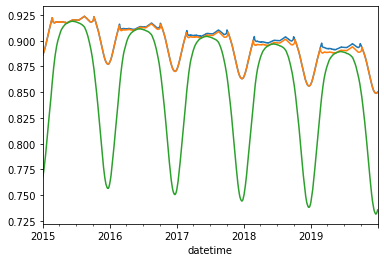

In [88]:
df_pkl[df_pkl.PI_clipping_basic.notna()].PI_clipping_basic.plot()
df_pkl[df_pkl.PI_clipping_flexible.notna()].PI_clipping_flexible.plot()
df_pkl[df_pkl.PI_clipping_universal.notna()].PI_clipping_universal.plot()
print(df_pkl.PI_clipping_basic.isna().sum())

In [ ]:
import_df_from_zip_pkl

<AxesSubplot:xlabel='datetime'>

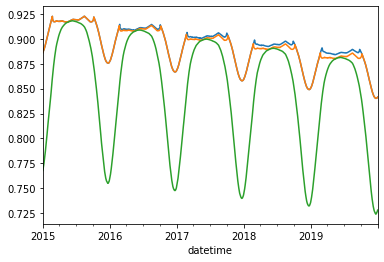

In [91]:
# test
#path = '../synthetic_soil_weather_pi_daily_001.pkl'
path = '../data/raw/synthetic_basic_pi_daily.zip'
#df_pi = pd.read_pickle(path, compression='gzip')
df_pi = import_df_from_zip_pkl(path, index=0, minofday=False)
#print(df_pi.PI_clipping_basic.isna().sum())

df_pi[df_pi.PI_clipping_basic.notna()].PI_clipping_basic.plot()
df_pi[df_pi.PI_clipping_flexible.notna()].PI_clipping_flexible.plot()
df_pi[df_pi.PI_clipping_universal.notna()].PI_clipping_universal.plot()


In [48]:
help(import_df_from_zip_pkl)

Help on function import_df_from_zip_pkl in module src.data.import_data:

import_df_from_zip_pkl(path_to_zip, index=0, verbose=False, minofday=True)
    Import a timeseries from a zipped pickled dataframe
    
    Extracts a dataframe file from the pickle (compressed using gzip)
    which is saved within a zipped folder
    
        Args:
            path_to_zip (str): path to the zip-file containing the pickled
                dataframes
            index (int, optional): index (0-49) of the desired timeseries,
                defaults to 0, ie, the first timeseries in the dataset
            verbose (bool, optional): print output if true, defaults to False
    
        Returns:
            data_frame (Pandas DataFrame): unpickled dataframe

